## Import Library

In [247]:
import time
import streamlit as st 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from help import HelpFunction, help_glucose

gender_map = {"Female":0,"Male":1}

# Program Prediksi Peluang Penyakit Diabetes
### Overview Data

In [248]:
myData = pd.read_csv('./dataset/diabetes.csv')
myData

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [249]:
myData.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Preproccessing Data

In [250]:
df = myData.copy()
df[['Glucose','BloodPressure','SkinThickness','BMI']] = myData[['Glucose','BloodPressure','SkinThickness','BMI']].replace(0,np.NaN)

In [251]:
def median_target(var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

median_target('Glucose')
df.loc[(df['Outcome'] == 0 ) & (df['Glucose'].isnull()), 'Glucose'] = 107
df.loc[(df['Outcome'] == 1 ) & (df['Glucose'].isnull()), 'Glucose'] = 140

median_target('BloodPressure')
df.loc[(df['Outcome'] == 0 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = 70
df.loc[(df['Outcome'] == 1 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

median_target('SkinThickness')
df.loc[(df['Outcome'] == 0 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = 27
df.loc[(df['Outcome'] == 1 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = 32

median_target('BMI')
df.loc[(df['Outcome'] == 0 ) & (df['BMI'].isnull()), 'BMI'] = 30.1
df.loc[(df['Outcome'] == 1 ) & (df['BMI'].isnull()), 'BMI'] = 34.3

In [252]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [253]:
df[['Pregnancies','BMI','Age','Outcome']]
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,0,26.6,0.351,31,0
2,8,183.0,64.0,32.0,0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168,43.1,2.288,33,1


In [254]:
len(df['BMI'].loc[df['BMI'] == 0].tolist())
df['BMI'] = df['BMI'].replace(0,df['BMI'].median())
len(df['BMI'].loc[df['BMI'] == 0].tolist())

0

### Melihat Correlation Matrix

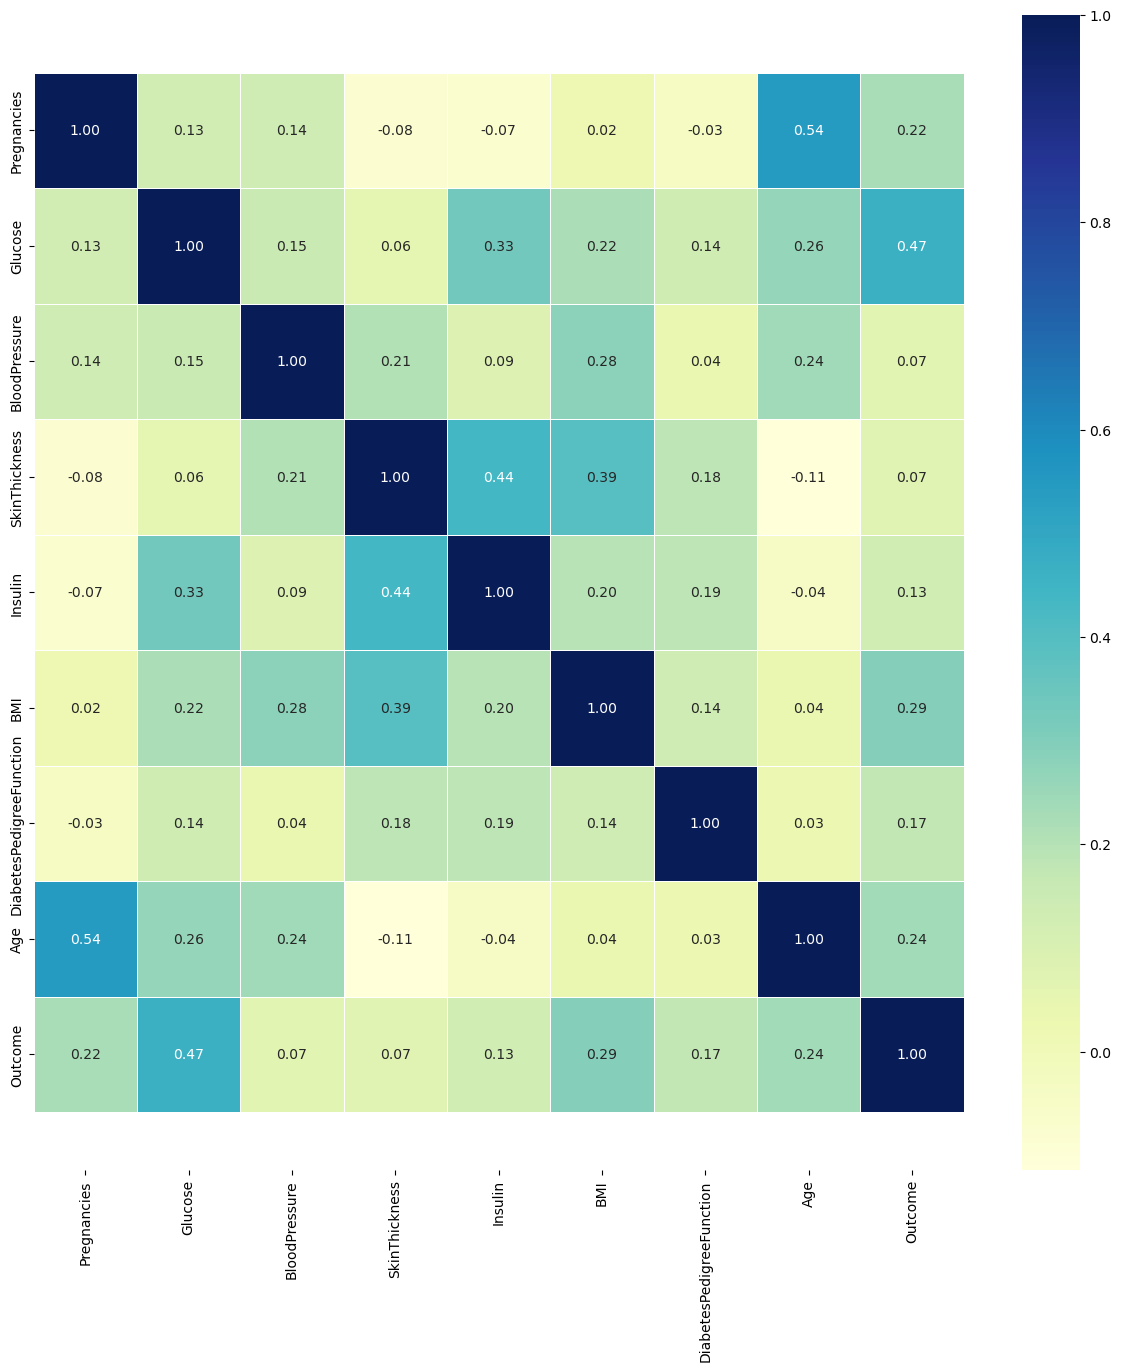

In [255]:
corr_matrix = myData.corr()
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(corr_matrix,
                annot = True,
                linewidths = 0.5,
                fmt = ".2f",
                cmap = "YlGnBu")
bottom, top = ax.get_ylim()
pr = ax.set_ylim(bottom + 0.5, top - 0.5)
with st.expander("Correlation Matrix"):
    fig
    pr

In [256]:
X_pp = df.drop(['Outcome'], axis=1)
X = preprocessing.scale(X_pp)
scaler = preprocessing.StandardScaler().fit(X_pp)
y = df['Outcome']

In [257]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [258]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, shuffle = True, test_size=0.2, random_state=0, stratify = y)
print(f"""{X_train.shape}  \n{X_test.shape}  \n{y_train.shape}  \n{y_test.shape} """)

(614, 8)  
(154, 8)  
(614,)  
(154,) 


In [259]:
list_model = []
list_acc = []
list_precision = []
list_recall = []

def evaluation(m):
    model = m
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = round(metrics.accuracy_score(y_test, y_pred),2)
    prec = round(metrics.precision_score(y_test, y_pred),2)
    recall = round(metrics.recall_score(y_test, y_pred),2)
    list_model.append(str(model).split('(')[0])
    list_acc.append(acc)
    list_precision.append(prec)
    list_recall.append(recall)
    print(f"""Accuracy : {acc} \nPrecision : {prec} \nRecall : {recall}""")

In [260]:
from sklearn.model_selection import GridSearchCV
model = KNeighborsClassifier()
leaf_size = list(range(1,15))
n_neighbors = list(range(10,50))
p=[1,2]
algrthm = ['auto', 'ball_tree', 'kd_tree', 'brute']
params = {
    'algorithm' : algrthm,
    'leaf_size' : leaf_size,
    'n_neighbors' : n_neighbors,
    'weights' : ['uniform','distance'],
    'metric' : ['euclidean','manhattan'],
    'p' : p
}

In [261]:
gsmdl = GridSearchCV(model, params, n_jobs=4, cv=5)
gsmdl.fit(X, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                         30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...],
                         'p': [1, 2], 'weights': ['uniform', 'distance']})

In [262]:
gsmdl.best_params_

{'algorithm': 'auto',
 'leaf_size': 1,
 'metric': 'manhattan',
 'n_neighbors': 18,
 'p': 1,
 'weights': 'distance'}

In [263]:
model = KNeighborsClassifier(**gsmdl.best_params_)
evaluation(model)

Accuracy : 0.8 
Precision : 0.81 
Recall : 0.56


In [264]:
accu = []
k = range(1,100)
for i in k:
  model = KNeighborsClassifier(n_neighbors=i)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  accu.append(round(metrics.accuracy_score(y_test, y_pred),5))

In [265]:
max(accu)

0.80519

In [266]:
dff = pd.DataFrame({'k' : k,'acc' : accu})
dff.sort_values(by='acc',ascending=False).head()

,k,acc
42,43,0.80519
41,42,0.80519
6,7,0.79870
60,61,0.79870
35,36,0.79221


In [267]:
model_knn = KNeighborsClassifier(n_neighbors=42)
evaluation(model_knn)

Accuracy : 0.81 
Precision : 0.9 
Recall : 0.5


In [268]:
model_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=42)

In [269]:
y_pred_knn = model_knn.predict(X_test)
y_pred_knn

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
      dtype=int64)

In [270]:
cm_knn = metrics.confusion_matrix(y_test, y_pred_knn)
cm_knn

array([[97,  3],
       [27, 27]], dtype=int64)

[Text(0, 0.5, 'Negatif'), Text(0, 1.5, 'Positif')]

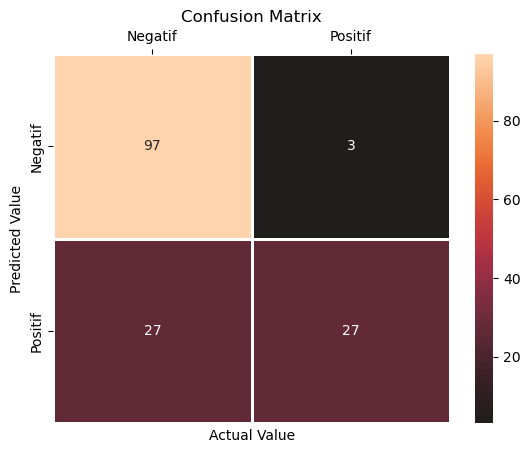

In [271]:
fig, ax = plt.subplots()
sns.heatmap(cm_knn, center=1, annot=True, fmt='g', ax=ax, linewidth=.8)
ax.xaxis.tick_top()
ax.set_title('Confusion Matrix')
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
ax.xaxis.set_ticklabels(['Negatif', 'Positif'])
ax.yaxis.set_ticklabels(['Negatif', 'Positif'])

In [272]:
acc_knn = metrics.accuracy_score(y_test, y_pred_knn)
prec_knn = metrics.precision_score(y_test, y_pred_knn)
rec_knn = metrics.recall_score(y_test, y_pred_knn)

acc_knn.round(2)

0.81

In [273]:
prec_knn.round(2)

0.9

In [274]:
rec_knn.round(2)

0.5

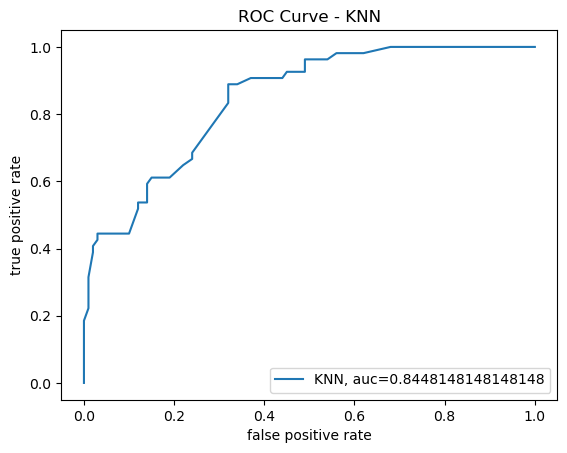

In [275]:
y_pred_knn_proba = model.predict_proba(X_test)[::,1]
fpr_knn, tpr_knn, _ = metrics.roc_curve(y_test,  y_pred_knn_proba)
auc_knn = metrics.roc_auc_score(y_test, y_pred_knn_proba)
plt.plot(fpr_knn,tpr_knn,label="KNN, auc="+str(auc_knn))
plt.title('ROC Curve - KNN')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()